In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [18]:
learning_rate=3e-4
z_dim=64
img_dim=28*28*1#784
batch_size=32
num_epochs=25

In [28]:
class Generator(nn.Module):
  def __init__(self,z_dim,img_dim):
    super(Generator,self).__init__()
    self.linear1=nn.Linear(z_dim,256)
    self.relu=nn.LeakyReLU(0.1)
    self.linear2=nn.Linear(256,img_dim)
    self.tanh=nn.Tanh()

  def forward(self,x):
    out=self.linear1(x)
    out=self.relu(out)
    out=self.linear2(out)
    out=self.tanh(out)
    return out

In [29]:
class Discriminator(nn.Module):
  def __init__(self,img_dim):
    super(Discriminator,self).__init__()
    self.linear1=nn.Linear(img_dim,128)
    self.relu=nn.LeakyReLU(0.1)
    self.linear2=nn.Linear(128,1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    out=self.linear1(x)
    out=self.relu(out)
    out=self.linear2(out)
    out=self.sigmoid(out)
    return out


In [30]:
discriminator=Discriminator(img_dim)
generator=Generator(z_dim,img_dim)
fix_noise=torch.randn((batch_size,z_dim))

In [31]:
#normalising and transforming
tf = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,), (0.5,)),]
)
dataset = torchvision.datasets.MNIST(root="dataset/", transform=tf, download=True)
loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

(-0.5, 241.5, 121.5, -0.5)

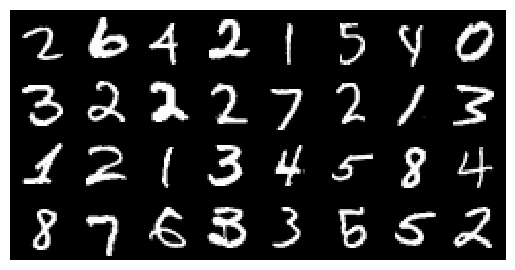

In [32]:
# Plotting real data to be fed to the discriminator
real_sample = next(iter(loader))[0]  # Get the next batch of real data
img_grid_real = torchvision.utils.make_grid(real_sample, normalize=True)
npgrid = img_grid_real.numpy()
plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
plt.axis('off')

In [33]:
#optmizers and loss
opt_discriminator=optim.Adam(discriminator.parameters(),lr=learning_rate)
opt_generator=optim.Adam(generator.parameters(),lr=learning_rate)
#loss
criterion=nn.BCELoss()


In [36]:
#discriminator wants to maximise the loss fun
#max log(D(real))+log(1-D(G(z)))
for epoch in range(num_epochs):
  for batch_idx, (real,_) in enumerate(loader):
    real=real.view(-1,784)
    batch_size=real.shape[0]
    #training discriminator
    noise=torch.randn(batch_size,z_dim)
    fake=generator(noise)
    #log(D(real))
    disc_real=discriminator(real).view(-1)
    lossD_real=criterion(disc_real,torch.ones_like(disc_real))
    #log(1-D(G(z)))
    disc_fake=discriminator(fake).view(-1)
    lossD_fake=criterion(disc_fake,torch.zeros_like(disc_fake))
    #total
    lossD=(lossD_real+lossD_fake)/2
    #update
    discriminator.zero_grad()
    lossD.backward(retain_graph=True)
    opt_discriminator.step()


    #generator wants to minimise log(1-D(G(z))) but it leads to saturating grads therfore we calculate -->max(log(D(G(z))))
    output=discriminator(fake).view(-1)
    lossG=criterion(output,torch.ones_like(output))
    generator.zero_grad()
    lossG.backward()
    opt_generator.step()

    if batch_idx == 0:
        print( "Epoch: {epoch} \t Discriminator Loss: {lossD} Generator Loss: {lossG}".format( epoch=epoch, lossD=lossD, lossG=lossG))





Epoch: 0 	 Discriminator Loss: 0.0003980107721872628 Generator Loss: 7.658862590789795
Epoch: 1 	 Discriminator Loss: 0.39810407161712646 Generator Loss: 1.4505550861358643
Epoch: 2 	 Discriminator Loss: 0.6576893329620361 Generator Loss: 0.7881022095680237
Epoch: 3 	 Discriminator Loss: 0.5599905252456665 Generator Loss: 1.0406436920166016
Epoch: 4 	 Discriminator Loss: 0.9049744606018066 Generator Loss: 0.7070537209510803
Epoch: 5 	 Discriminator Loss: 0.4802393913269043 Generator Loss: 1.28334641456604
Epoch: 6 	 Discriminator Loss: 0.8315108418464661 Generator Loss: 0.5312680602073669
Epoch: 7 	 Discriminator Loss: 0.6394275426864624 Generator Loss: 0.9799378514289856
Epoch: 8 	 Discriminator Loss: 0.5852160453796387 Generator Loss: 1.0739009380340576
Epoch: 9 	 Discriminator Loss: 0.8009567260742188 Generator Loss: 0.7860665321350098
Epoch: 10 	 Discriminator Loss: 0.5135087370872498 Generator Loss: 1.468612790107727
Epoch: 11 	 Discriminator Loss: 0.8837442994117737 Generator Los

(-0.5, 241.5, 121.5, -0.5)

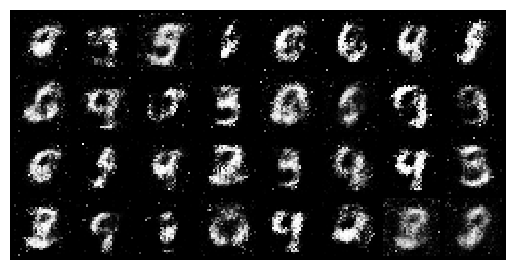

In [37]:

fake = generator(noise).reshape(-1, 1, 28, 28)
img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
npgrid = img_grid_fake.cpu().numpy()
plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
plt.axis('off')
